In [ ]:
import tensorflow as tf
import numpy as np
from time import time
from IPython import display

from vae import VAE, optimizer, train_step, compute_loss
from vae.config import config

import matplotlib.pyplot as plt
import imageio
import PIL
%matplotlib inline

# VAE

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(config.train_size).batch(config.batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(config.test_size).batch(config.batch_size))

### Training

In [ ]:
epochs = 10
num_examples = 16

In [ ]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples, config.latent_dim])
model = VAE(config)

In [ ]:
def generate_and_save_images(model, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert config.batch_size >= num_examples
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples, :, :, :]

Epoch: 10, Test set ELBO: -156.47317504882812, time elapse for current epoch: 8.708777666091919


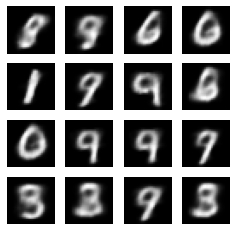

In [ ]:
generate_and_save_images(model, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, test_sample)
